# COVID Global Clustering


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False).transpose()
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail(3))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False).transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index)
display('deaths',dfd_g.tail(3))


'cases'

Country/Region,US,India,France,Germany,Brazil,Japan,"Korea, South",Italy,United Kingdom,Russia,...,Nauru,Kiribati,Tuvalu,Summer Olympics 2020,Diamond Princess,Winter Olympics 2022,Holy See,Antarctica,MS Zaandam,"Korea, North"
2023-03-07,103690910,44689919,39854299,38231610,37076053,33298799,30594297,25603510,24629846,22051220,...,5247,5013,2805,865,712,535,29,11,9,1
2023-03-08,103755771,44690298,39860410,38241231,37076053,33310604,30605187,25603510,24629922,22063473,...,5247,5014,2805,865,712,535,29,11,9,1
2023-03-09,103802702,44690738,39866718,38249060,37076053,33320438,30615522,25603510,24658705,22075858,...,5247,5014,2805,865,712,535,29,11,9,1


'deaths'

Country/Region,US,Brazil,India,Russia,Mexico,United Kingdom,Peru,Italy,Germany,France,...,Tonga,Palau,"Korea, North",MS Zaandam,Nauru,Summer Olympics 2020,Winter Olympics 2022,Antarctica,Tuvalu,Holy See
2023-03-07,1122516,699276,530775,388396,333136,220721,219513,188322,168709,166138,...,13,9,6,2,1,0,0,0,0,0
2023-03-08,1123246,699276,530776,388440,333170,220721,219539,188322,168808,166165,...,13,9,6,2,1,0,0,0,0,0
2023-03-09,1123836,699276,530779,388478,333188,220721,219539,188322,168935,166176,...,13,9,6,2,1,0,0,0,0,0


## Add Trailing Avg Changes 3-day 7-day 14day

In [2]:
df_rolls = dfc_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(columns={df_rolls.columns[0]:'Cases3dayAvg'})
df_rolls['Cases7dayAvg'] = dfc_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Cases14dayAvg'] = dfc_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls['Deaths3dayAvg'] = dfd_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls['Deaths7dayAvg'] = dfd_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Deaths14dayAvg'] = dfd_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(index={'US':'United States'})
df_rolls.head()


,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,
United States,49054.333333,30420.714286,31227.928571,551.666667,311.142857,308.214286
India,381.666667,335.714286,278.285714,1.333333,1.000000,1.071429
France,6494.000000,4403.142857,4052.642857,20.666667,18.000000,20.500000
Germany,12736.333333,6641.285714,11355.071429,179.333333,91.285714,86.571429
Brazil,0.000000,1798.428571,4793.500000,0.000000,11.285714,31.571429


## Add Global Population by Country

In [3]:
# GLobal Population
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'RUS','Country Name'] = 'Russia'
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'IRN','Country Name'] = 'Iran'
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'COD','Country Name'] = 'Congo'
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})
display(df_gpop_2016[df_gpop_2016['Country/Region'].isin(['Italy','Russian Federation','Russia'])])

df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })

# merge rolling averages
df_gmerged = pd.merge(left=df_gmerged, right=df_rolls, on='Country/Region')

display(df_gmerged.sort_values(by=['Population'], ascending=False).head(10))
display(dfc_g.iloc[0:1,:].count(axis=1), df_gmerged['Country/Region'].count())  # join check 185 in -> 159 out ?


,Country/Region,Country Code,Year,Value
7186,Italy,ITA,2016,60627498
12488,Russia,RUS,2016,144342397


,Country/Region,Deaths,Cases,Country Code,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
18,China,101056,4903524,CHN,2016,1387790000,0.000000,0.000000,0.071429,0.333333,0.714286,1.428571
2,India,530779,44690738,IND,2016,1338636340,381.666667,335.714286,278.285714,1.333333,1.000000,1.071429
0,United States,1123836,103802702,USA,2016,323071755,49054.333333,30420.714286,31227.928571,551.666667,311.142857,308.214286
10,Indonesia,160941,6738225,IDN,2016,261850182,307.333333,235.571429,228.000000,3.000000,3.000000,3.142857
33,Pakistan,30644,1577411,PAK,2016,213524840,56.000000,48.428571,44.000000,0.333333,0.142857,0.214286
1,Brazil,699276,37076053,BRA,2016,206859578,0.000000,1798.428571,4793.500000,0.000000,11.285714,31.571429
93,Nigeria,3155,266598,NGA,2016,188666931,0.000000,0.000000,9.642857,0.000000,0.000000,0.000000
34,Bangladesh,29445,2037871,BGD,2016,159784568,14.000000,6.000000,7.000000,0.000000,0.000000,0.000000
3,Russia,388478,22075858,RUS,2016,144342397,11661.000000,12535.428571,12031.571429,41.000000,39.571429,36.357143
19,Japan,72997,33320438,JPN,2016,127076000,11268.333333,9678.857143,10506.214286,61.333333,59.428571,67.000000


2020-01-22    201
dtype: int64

174

## Add Various Other Data from WorldBank.Org

In [4]:
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def get_zip(url):
    urllib.request.urlretrieve(url, "X.zip")
    compressed_file = zipfile.ZipFile('X.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)
            return pd.read_csv(csv_file, header=2)
    return None

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code')
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [5]:
df_gmerged3 = df_gmerged.copy()

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False) # 0 data for g10's
#df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('IS.SHP.GOOD.TU', 'shipping', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.LE00.IN', 'lifeExpYrs', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FP.CPI.TOTL.ZG', 'inflation', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.TFRT.IN', 'fertility', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)

df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])
df_gmerged3.head()

HTTPError: ignored

In [6]:
df_gmerged3.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Country/Region,United States,Brazil,India,Russia,Mexico,United Kingdom,Peru,Italy,Germany,France
Deaths,1123836,699276,530779,388478,333188,220721,219539,188322,168935,166176
Cases,103802702,37076053,44690738,22075858,7483444,24658705,4487553,25603510,38249060,39866718
Country Code,USA,BRA,IND,RUS,MEX,GBR,PER,ITA,DEU,FRA
Year,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
Population,323071755,206859578,1338636340,144342397,121519221,65611593,31132779,60627498,82348669,66724104
Cases3dayAvg,49054.333333,0.0,381.666667,11661.0,4263.666667,9621.666667,206.333333,0.0,12736.333333,6494.0
Cases7dayAvg,30420.714286,1798.428571,335.714286,12535.428571,3369.142857,4125.0,397.714286,3808.285714,6641.285714,4403.142857
Cases14dayAvg,31227.928571,4793.5,278.285714,12031.571429,2878.071429,3952.5,198.857143,4006.857143,11355.071429,4052.642857
Deaths3dayAvg,551.666667,0.0,1.333333,41.0,29.333333,0.0,8.666667,0.0,179.333333,20.666667


# Correlation Matrix

<ipython-input-7-a9423c163b7a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_gmerged3.corr()
<ipython-input-7-a9423c163b7a>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
<ipython-input-7-a9423c163b7a>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will 

,Deaths,Cases,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Deaths,1.000000,0.894572,NaN,0.449950,0.749758,0.775837,0.786532,0.720172,0.756983,0.778057
Cases,0.894572,1.000000,NaN,0.399419,0.851447,0.860659,0.881776,0.808450,0.847709,0.863495
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Population,0.449950,0.399419,NaN,1.000000,0.157646,0.166323,0.168486,0.150665,0.161312,0.167198
Cases3dayAvg,0.749758,0.851447,NaN,0.157646,1.000000,0.974087,0.967740,0.952764,0.959685,0.953623
Cases7dayAvg,0.775837,0.860659,NaN,0.166323,0.974087,1.000000,0.988964,0.905039,0.940425,0.939141
Cases14dayAvg,0.786532,0.881776,NaN,0.168486,0.967740,0.988964,1.000000,0.914412,0.946745,0.949259
Deaths3dayAvg,0.720172,0.808450,NaN,0.150665,0.952764,0.905039,0.914412,1.000000,0.988411,0.980654
Deaths7dayAvg,0.756983,0.847709,NaN,0.161312,0.959685,0.940425,0.946745,0.988411,1.000000,0.997150
Deaths14dayAvg,0.778057,0.863495,NaN,0.167198,0.953623,0.939141,0.949259,0.980654,0.997150,1.000000


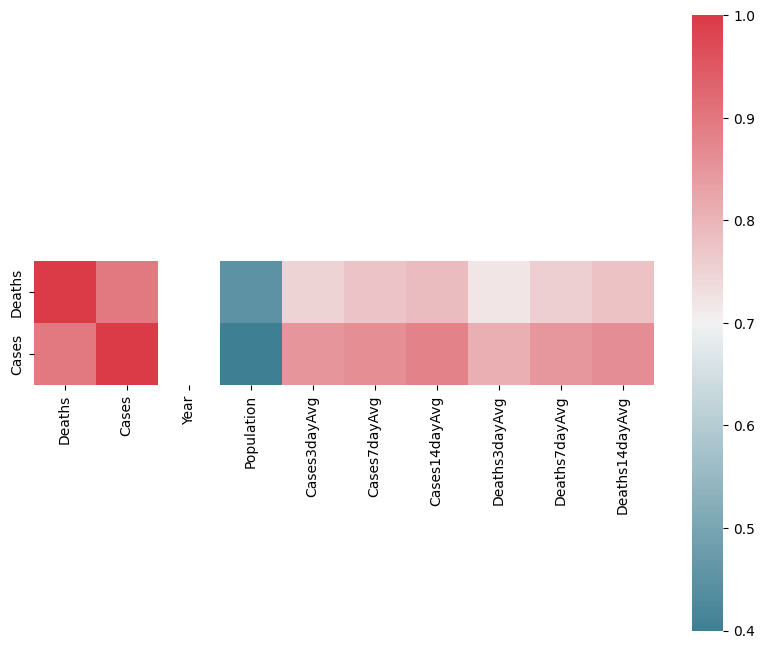

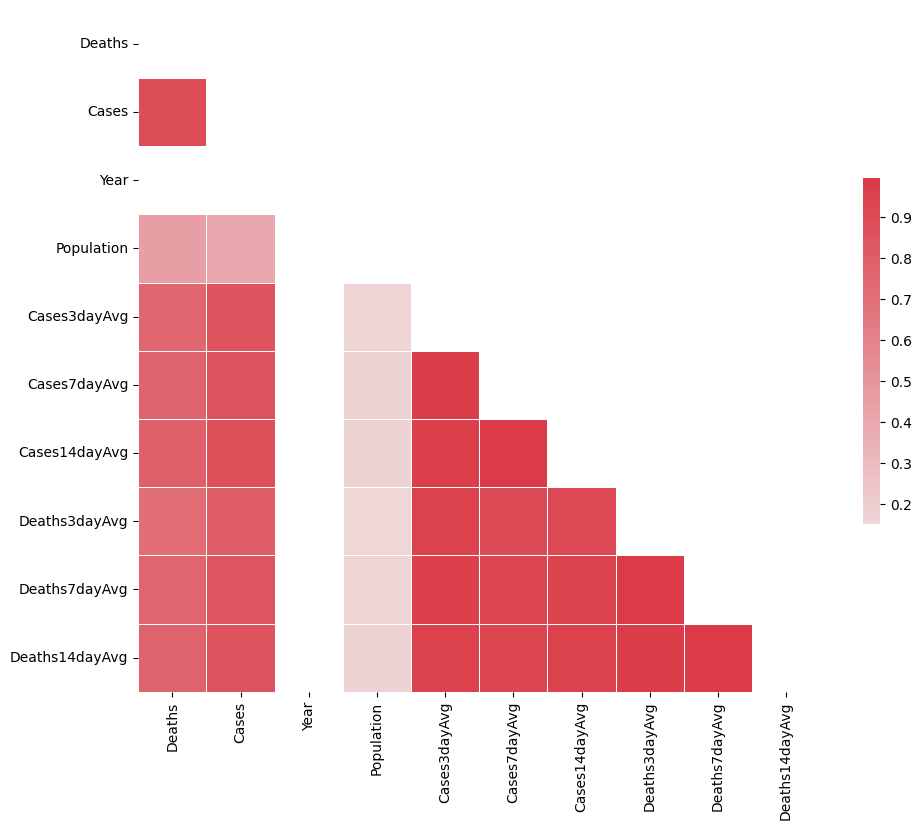

In [7]:
import seaborn as sns

df_corr = df_gmerged3.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [8]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_orig = df_gmerged3.copy().set_index('Country/Region').drop(columns=['Country Code'])
df_sc = pd.DataFrame(scaler.fit_transform(df_orig), index=df_orig.index, columns=df_orig.columns)

display('original',df_orig.head(2),'scaled',df_sc.head(2))

'original'

,Deaths,Cases,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,,,,,
United States,1123836,103802702,2016,323071755,49054.333333,30420.714286,31227.928571,551.666667,311.142857,308.214286
Brazil,699276,37076053,2016,206859578,0.000000,1798.428571,4793.500000,0.000000,11.285714,31.571429


'scaled'

,Deaths,Cases,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,,,,,
United States,9.196044,9.528505,0.0,1.885533,11.639418,10.990622,10.683155,12.300407,12.146881,12.089278
Brazil,5.599791,3.187986,0.0,1.111565,-0.208649,0.432145,1.440895,-0.157295,0.262467,1.065235


# Misc Clustering Techniques

## - Basic Template for KMeans

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

df_train = df_sc.copy()

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'kmeans info - inertia: {kmeans.inertia_}, iters: {kmeans.n_iter_}')    # training info
display(f'labels: {kmeans.labels_}')                       # k-labels

def fl_col(df, f=3, l=9):  # print first 3 and last 2 cols together
    return pd.concat([df.iloc[:,0:f],df.iloc[:,-l:]], axis=1)

df_train.insert(0, 'cluster', kmeans.labels_)
display('train', fl_col(pd.concat([df_train.head(5),
                            df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])]])))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'kmeans info - inertia: 309.26746164731895, iters: 3'

'labels: [1 2 2 2 2 2 0 2 2 2 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]'

'train'

,cluster,Deaths,Cases,Cases,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,,,,,,,
United States,1,9.196044,9.528505,9.528505,0.0,1.885533,11.639418,10.990622,10.683155,12.300407,12.146881,12.089278
Brazil,2,5.599791,3.187986,3.187986,0.0,1.111565,-0.208649,0.432145,1.440895,-0.157295,0.262467,1.065235
India,2,4.172530,3.911551,3.911551,0.0,8.649141,-0.116465,-0.107436,-0.137758,-0.127186,-0.145193,-0.150171
Russia,2,2.967164,1.762633,1.762633,0.0,0.695204,2.607826,4.392918,3.971539,0.768565,1.383531,1.255942
Mexico,2,2.498828,0.376029,0.376029,0.0,0.543203,0.821152,1.011566,0.771204,0.505109,0.664465,0.518729
United States,1,9.196044,9.528505,9.528505,0.0,1.885533,11.639418,10.990622,10.683155,12.300407,12.146881,12.089278
India,2,4.172530,3.911551,3.911551,0.0,8.649141,-0.116465,-0.107436,-0.137758,-0.127186,-0.145193,-0.150171
Italy,2,1.271734,2.097839,2.097839,0.0,0.137667,-0.208649,1.173561,1.165861,-0.157295,1.106096,1.150626
Spain,0,0.688597,0.973432,0.973432,0.0,0.043473,-0.208649,0.142513,0.126387,-0.157295,0.375706,0.641123


,Cases
cluster,
0,163
1,1
2,10


In [10]:
from sklearn.cluster import DBSCAN
import numpy as np

df_train = df_sc.copy()
clustering = DBSCAN(eps=3, min_samples=2).fit(df_train)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')
display(f'labels/fit_predict[0:10]: {labels[0:10]}')

df_train.insert(0, 'cluster',clustering.labels_)
display('train2',pd.concat([fl_col(df_train).head(),
                            fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))


'model: DBSCAN(eps=3, min_samples=2)'

'core_sample_indices_[0:10]: [ 4  5  6  7  9 10 11 12 13 14]'

'components_[0]: [2.49882777 0.37602873 0.         0.54320303 0.82115248 1.01156568\n 0.77120437 0.50510862 0.66446459 0.51872889]'

'labels/fit_predict[0:10]: [-1 -1 -1 -1  0  0  0  0 -1  0]'

'train2'

,cluster,Deaths,Cases,Cases,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,,,,,,,
United States,-1,9.196044,9.528505,9.528505,0.0,1.885533,11.639418,10.990622,10.683155,12.300407,12.146881,12.089278
Brazil,-1,5.599791,3.187986,3.187986,0.0,1.111565,-0.208649,0.432145,1.440895,-0.157295,0.262467,1.065235
India,-1,4.172530,3.911551,3.911551,0.0,8.649141,-0.116465,-0.107436,-0.137758,-0.127186,-0.145193,-0.150171
Russia,-1,2.967164,1.762633,1.762633,0.0,0.695204,2.607826,4.392918,3.971539,0.768565,1.383531,1.255942
Mexico,0,2.498828,0.376029,0.376029,0.0,0.543203,0.821152,1.011566,0.771204,0.505109,0.664465,0.518729
United States,-1,9.196044,9.528505,9.528505,0.0,1.885533,11.639418,10.990622,10.683155,12.300407,12.146881,12.089278
India,-1,4.172530,3.911551,3.911551,0.0,8.649141,-0.116465,-0.107436,-0.137758,-0.127186,-0.145193,-0.150171
Italy,0,1.271734,2.097839,2.097839,0.0,0.137667,-0.208649,1.173561,1.165861,-0.157295,1.106096,1.150626
Spain,0,0.688597,0.973432,0.973432,0.0,0.043473,-0.208649,0.142513,0.126387,-0.157295,0.375706,0.641123


,Count
cluster,
-1,7
0,167


---

# Dimension Reduction

## - PCA Method

Most research tells us due to "Curse of Dimensionality" that you need to reduce dims before you run clustering.  Hence we redo.

[Text(0, 0.5, 'PCA3')]

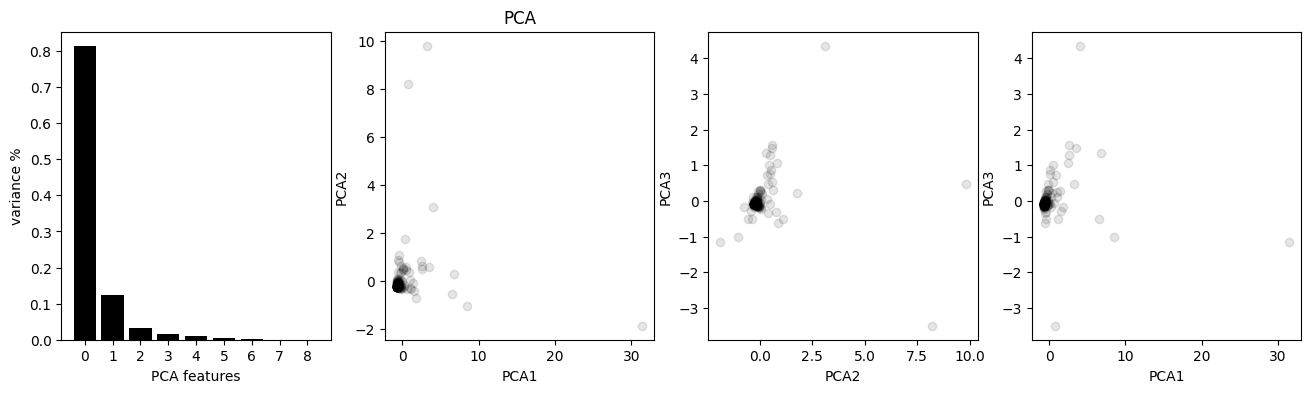

In [11]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_sc.copy()

pca = PCA(n_components='mle')
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')
ax[1].set(title='PCA')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')



##

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

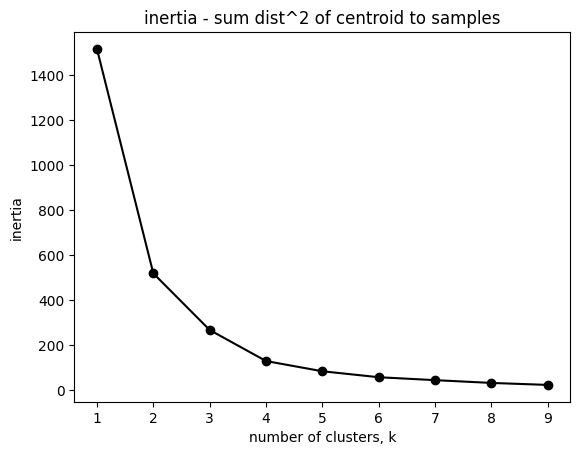

In [12]:
# KMeans on PCA columns - the elbow check !
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:,:3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

elbow_check(PCA_components)

## KMeans Cluster Variants and Plots

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

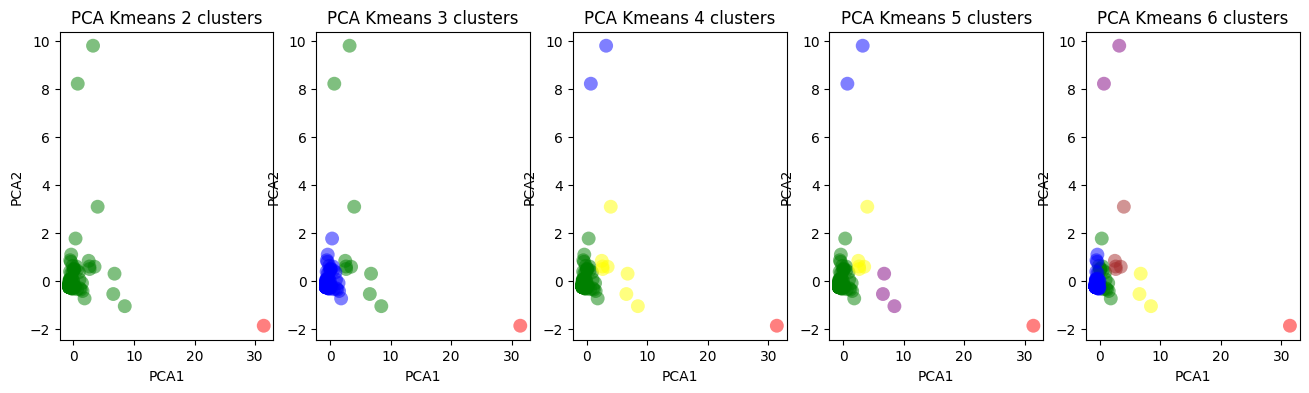

In [13]:
cluster_cases = [2,3,4,5,6]

def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
#        m = model.fit(df_comp2.iloc[:,:dims])
        m = model.fit(df_comp2)
        df_comp2.insert(0, 'cluster', m.labels_)

        datas = []
        for i in range(clusters):
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

# hmm which one to pick?
plot_clusters('PCA', cluster_cases, PCA_components)



## KMeans with Point Labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


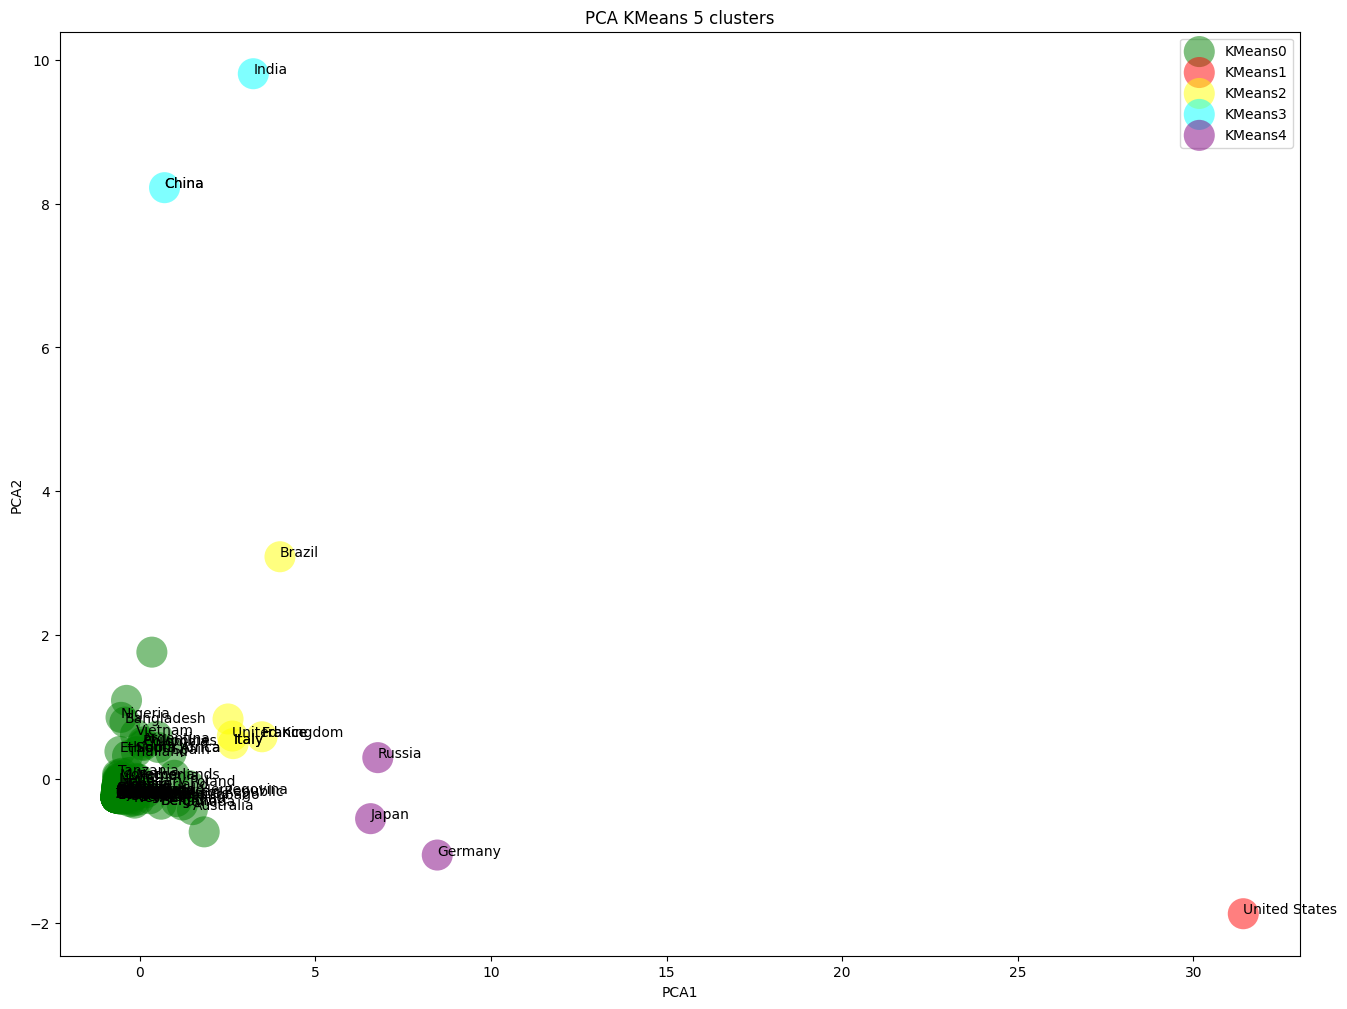

In [14]:
def plot_big(clustering_name, reducer_name, model, df_comp, dims=2, countries=30):
    df_comp2 = df_comp.copy()
    fig,ax = plt.subplots(figsize=(16,12))

    m = model.fit(df_comp2)  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', m.labels_)

    datas = []
    for i in range(len(set(m.labels_))):
        tup = []
        for j in range(dims):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)

    groups = [clustering_name+str(i) for i in range(len(set(m.labels_)))]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=500, label=group)
        ax.set_title(f'{reducer_name} {clustering_name} {len(set(m.labels_))} clusters')
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')

    for index,row in df_comp2[df_comp2.index.isin(['United Kingdom','Belgium','Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Sweden', 'Switzerland','Canada','Japan','United States','China','Australia','Singapore','South Africa','Belarus','Brazil','Russia','India','Poland'])].iterrows():
        ax.annotate(index, (row[0],row[1]))
    for index,row in df_comp2.sample(countries).iterrows():
        ax.annotate(index, (row[0],row[1]))

    plt.legend(loc=1)
    plt.show()

# zoom on n cluster solution
clusters=5
model = KMeans(n_clusters=clusters)
plot_big('KMeans','PCA',model, PCA_components, countries=50)


## -T-SNE Method (T-Distributed Stochastic Neighbor Embedding)

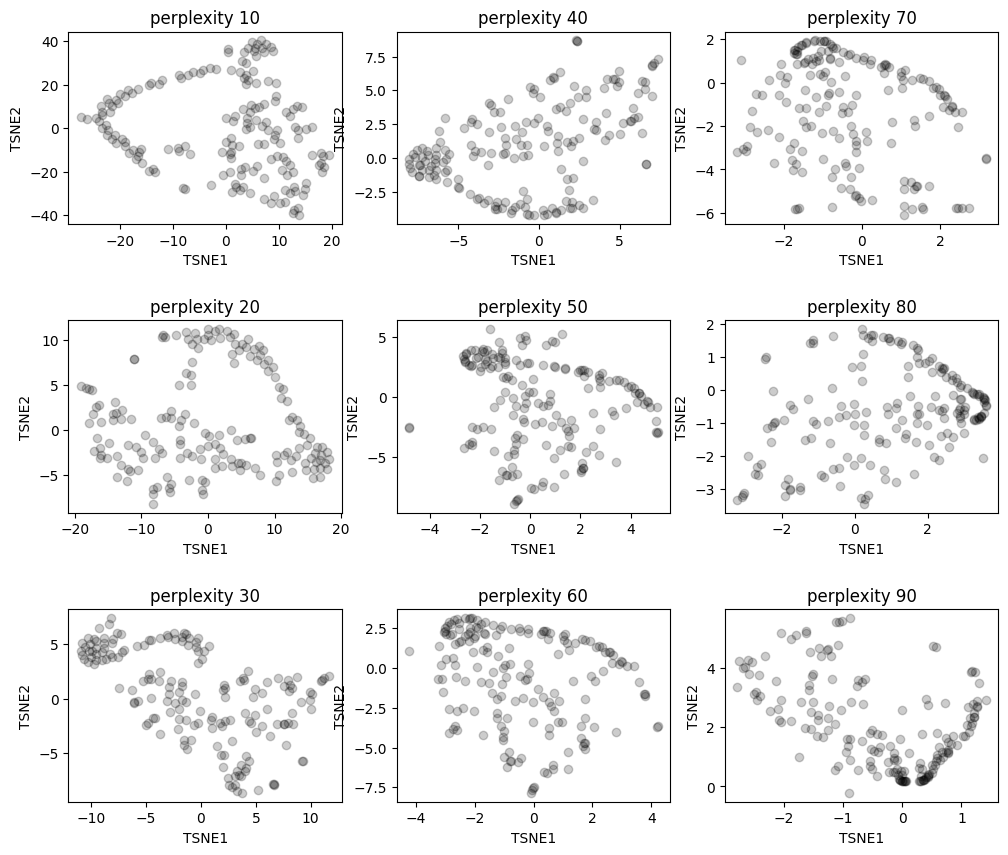

In [15]:
plotX = df_train.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')


## Fixing TSNE HyperParams (Perplexity and Comps)

In [16]:
# pick perp 30 randomly, comps 2 or 3 (plot dimensions I think)
tsne = TSNE(n_components=2, perplexity=30)
tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)
TSNE_components.head()

,0,1
Country/Region,,
United States,11.718494,2.110059
Brazil,10.057343,-0.934790
India,9.275265,-5.714064
Russia,10.944800,1.609015
Mexico,9.145087,-0.327455


## KMeans w/ TSNE

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

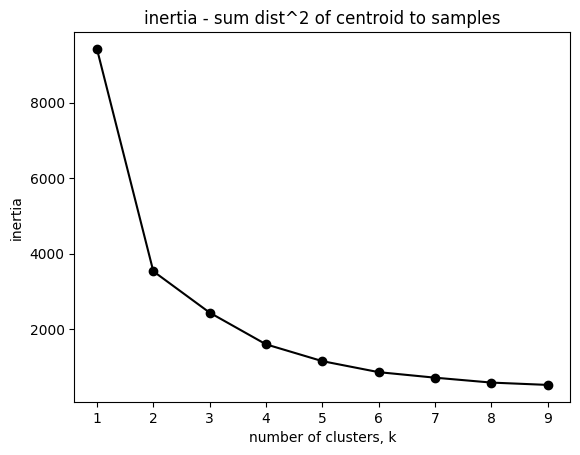

In [17]:
# KMeans on TSNE columns, search or the elbow ?

elbow_check(TSNE_components)

## KMeans on TSNE Cluster Analysis

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

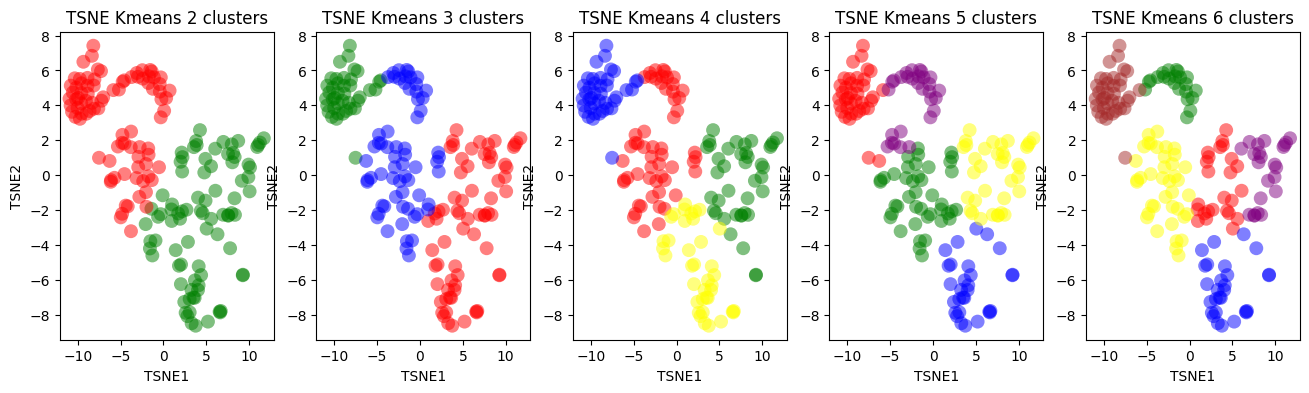

In [18]:
cluster_cases = [2,3,4,5,6]
plot_clusters('TSNE', cluster_cases, TSNE_components)

# hmm which one to pick?

## KMeans on TSNE - Zoom with Labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


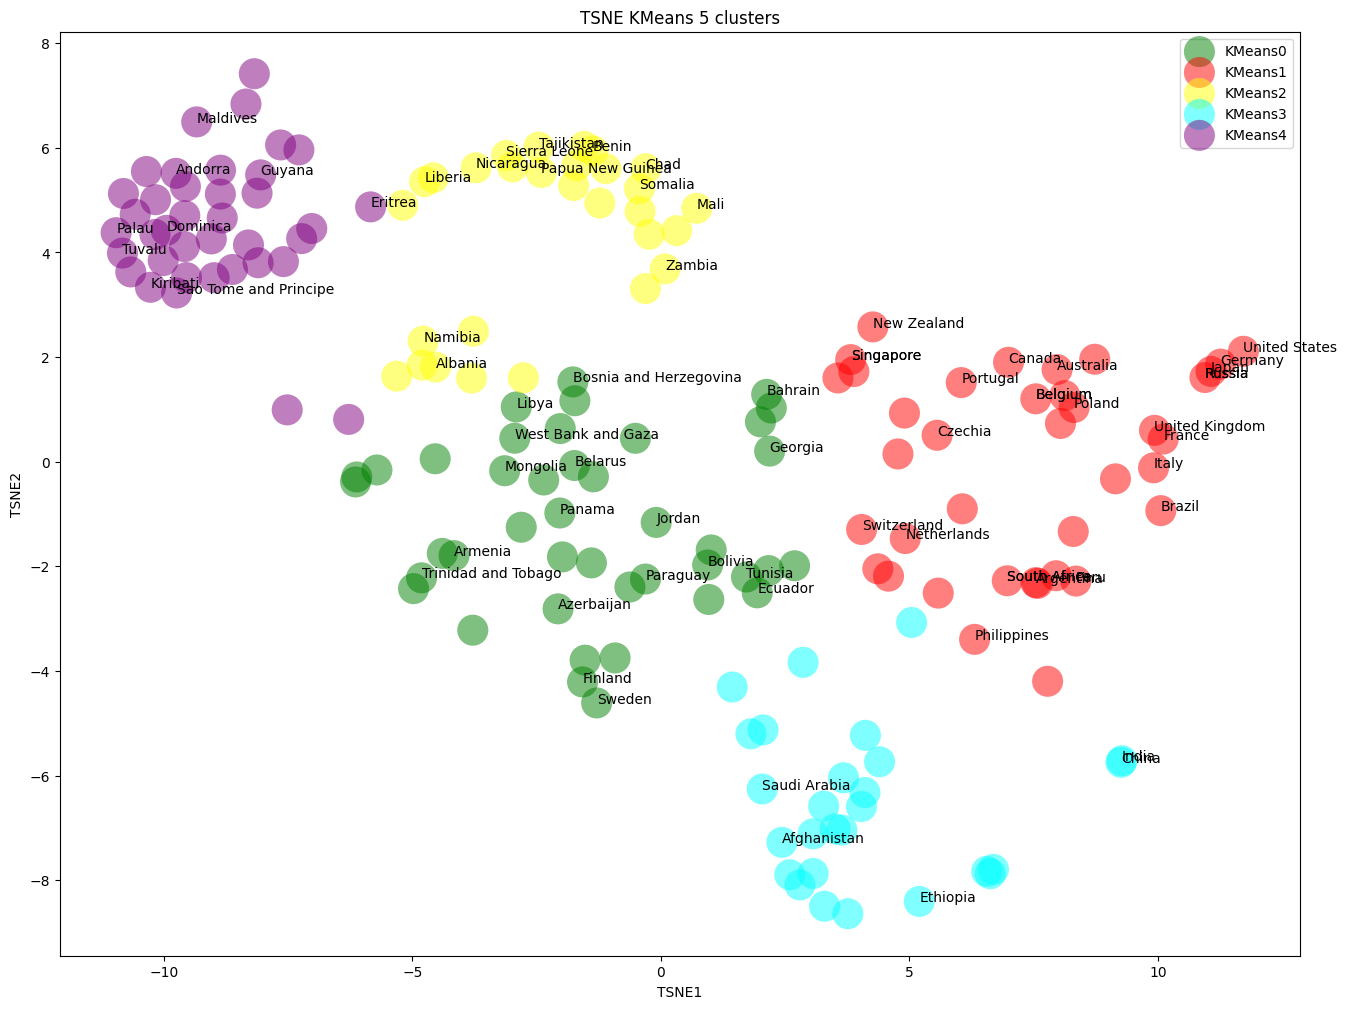

In [19]:
# try 6 clusters -- why i dunno, looks good...
model = KMeans(n_clusters=5)
plot_big('KMeans','TSNE',model, TSNE_components, countries=50)

---
## DBScan on PCA Cluster Analysis


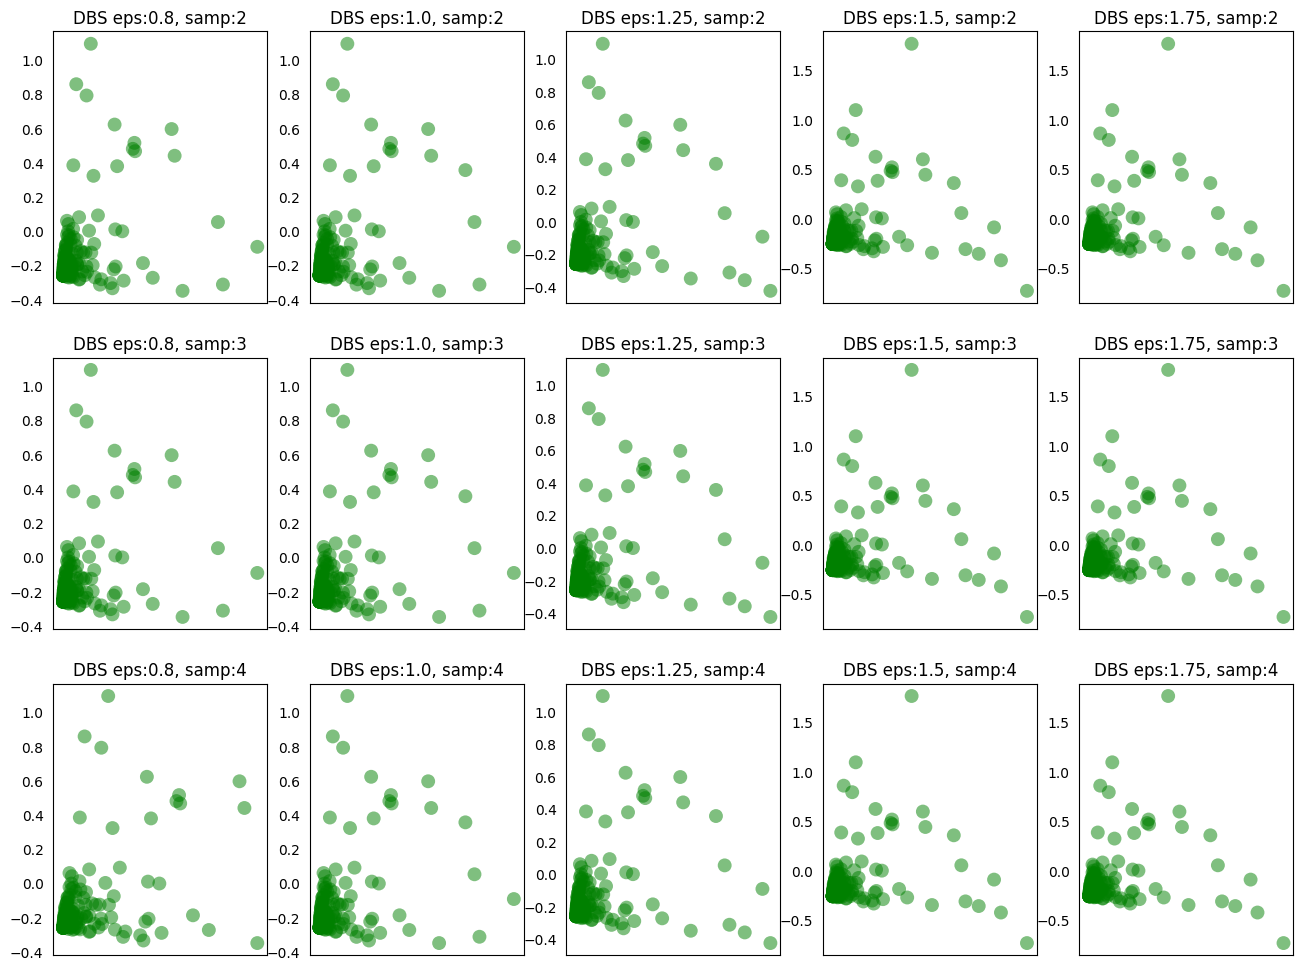

In [20]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product

# try a variety of eps & samples
samp_list = [2,3,4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rl = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(16,12))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    PCA_components3 = PCA_components.copy()

    ax[k%rl][math.floor(k/rl)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False)
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(PCA_components3)
    PCA_components3.insert(0, 'cluster', clustering.labels_)

    datas = []
    for i in range(len(set(clustering.labels_))):
        tup = [PCA_components3[PCA_components3['cluster']==i][j] for j in range(2)]
        datas.append(tup)

    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[k%rl][math.floor(k/rl)].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rl][math.floor(k/rl)].set_title(f'DBS eps:{eps}, samp:{samp}')


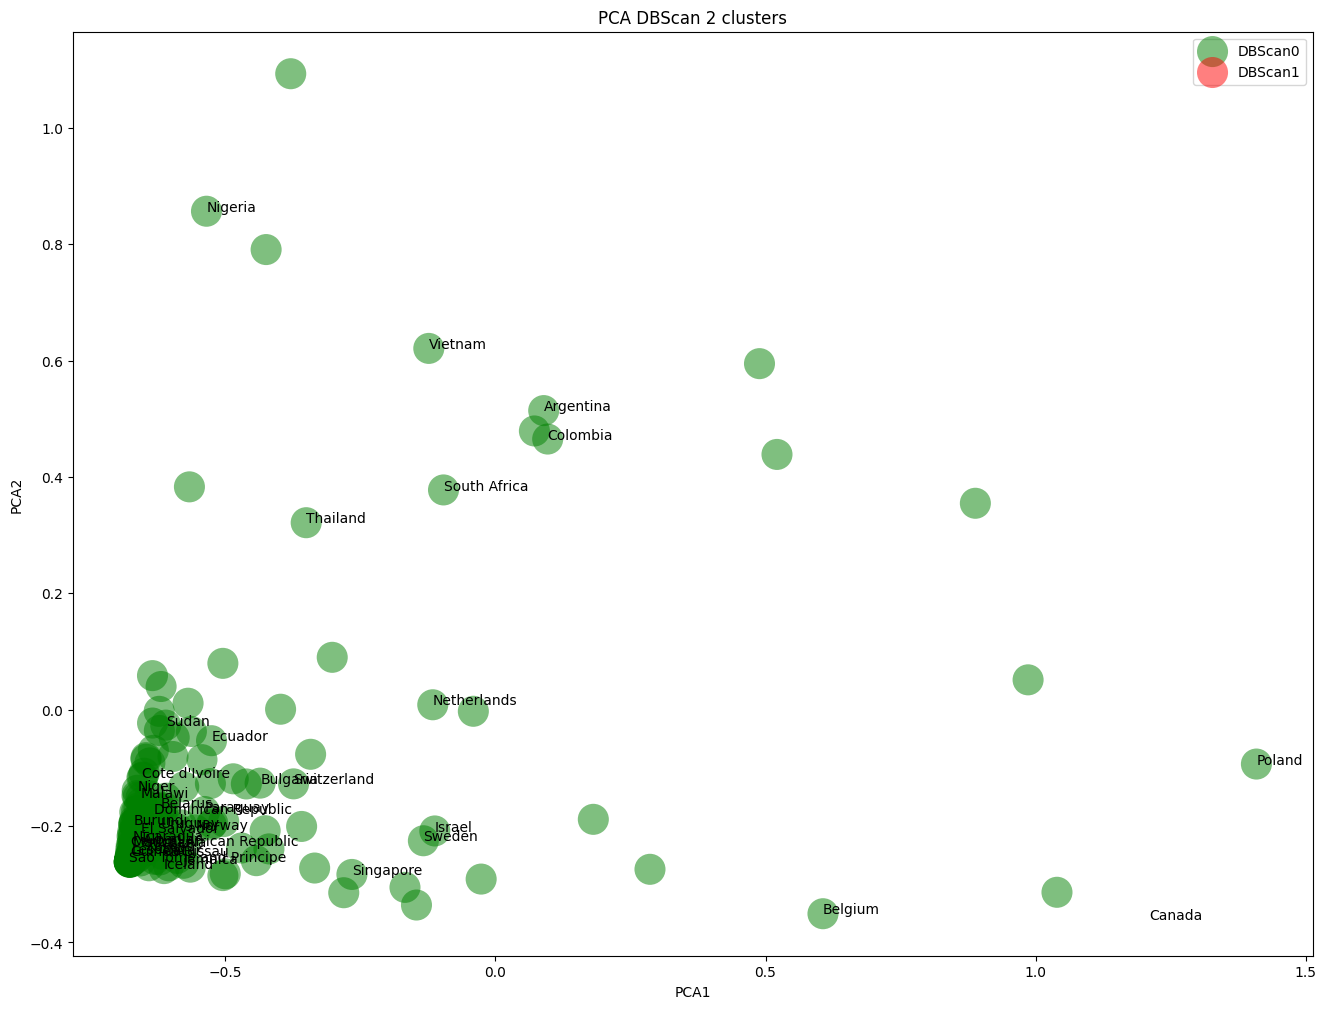

In [21]:
PCA_components3 = PCA_components.copy()
clustering = DBSCAN(eps=1, min_samples=3).fit(PCA_components3)
plot_big('DBScan','PCA',clustering, PCA_components3) # bug w/ DBAcan use ..'


## DBScan on TSNE Cluster Analysis

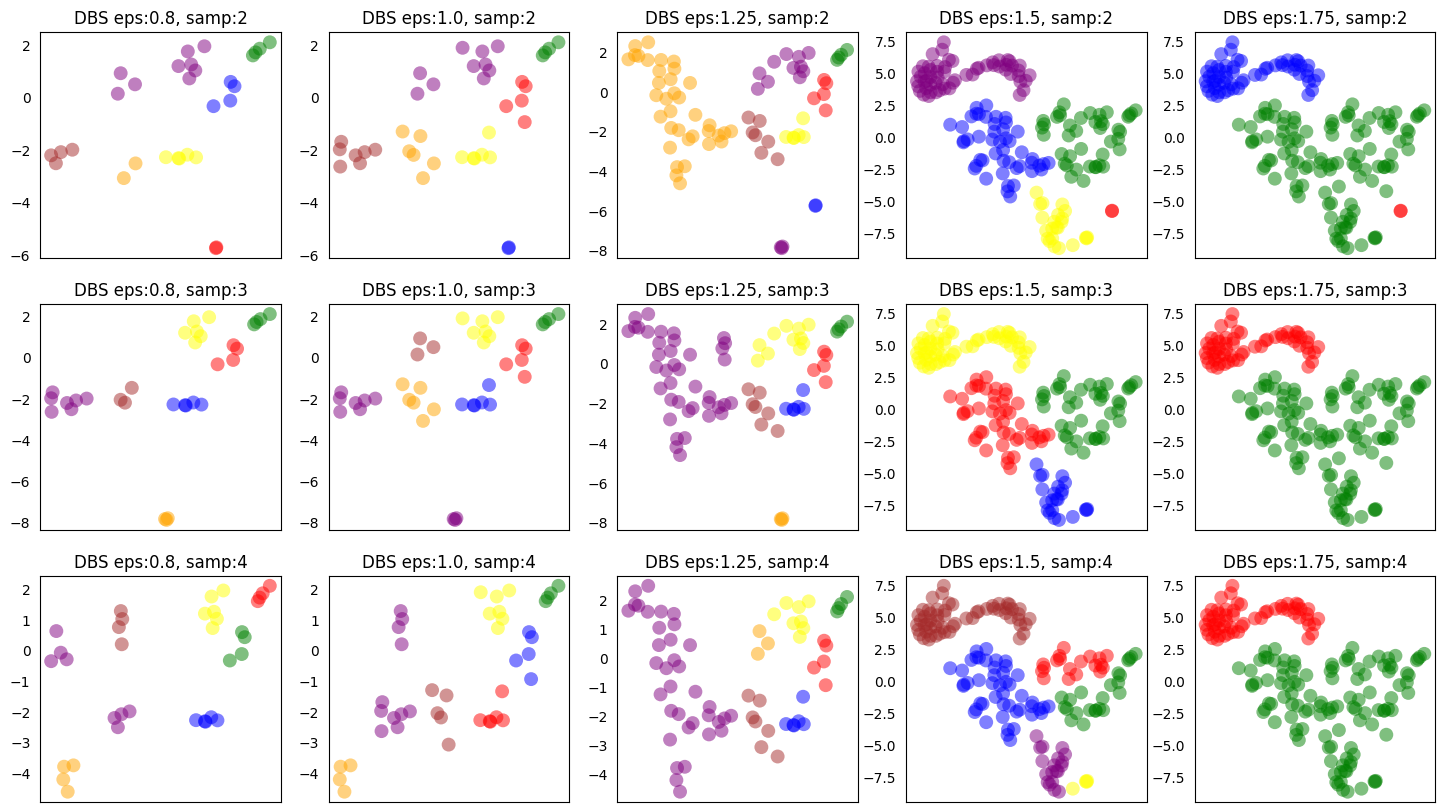

In [22]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product
from math import floor

samp_list = [2,3,4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18,10))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rows][floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False)

    TSNE_df = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_df)
    TSNE_df.insert(0, 'cluster', clustering.labels_)

    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        ax[k%rows][floor(k/rows)].scatter(data[0],data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')


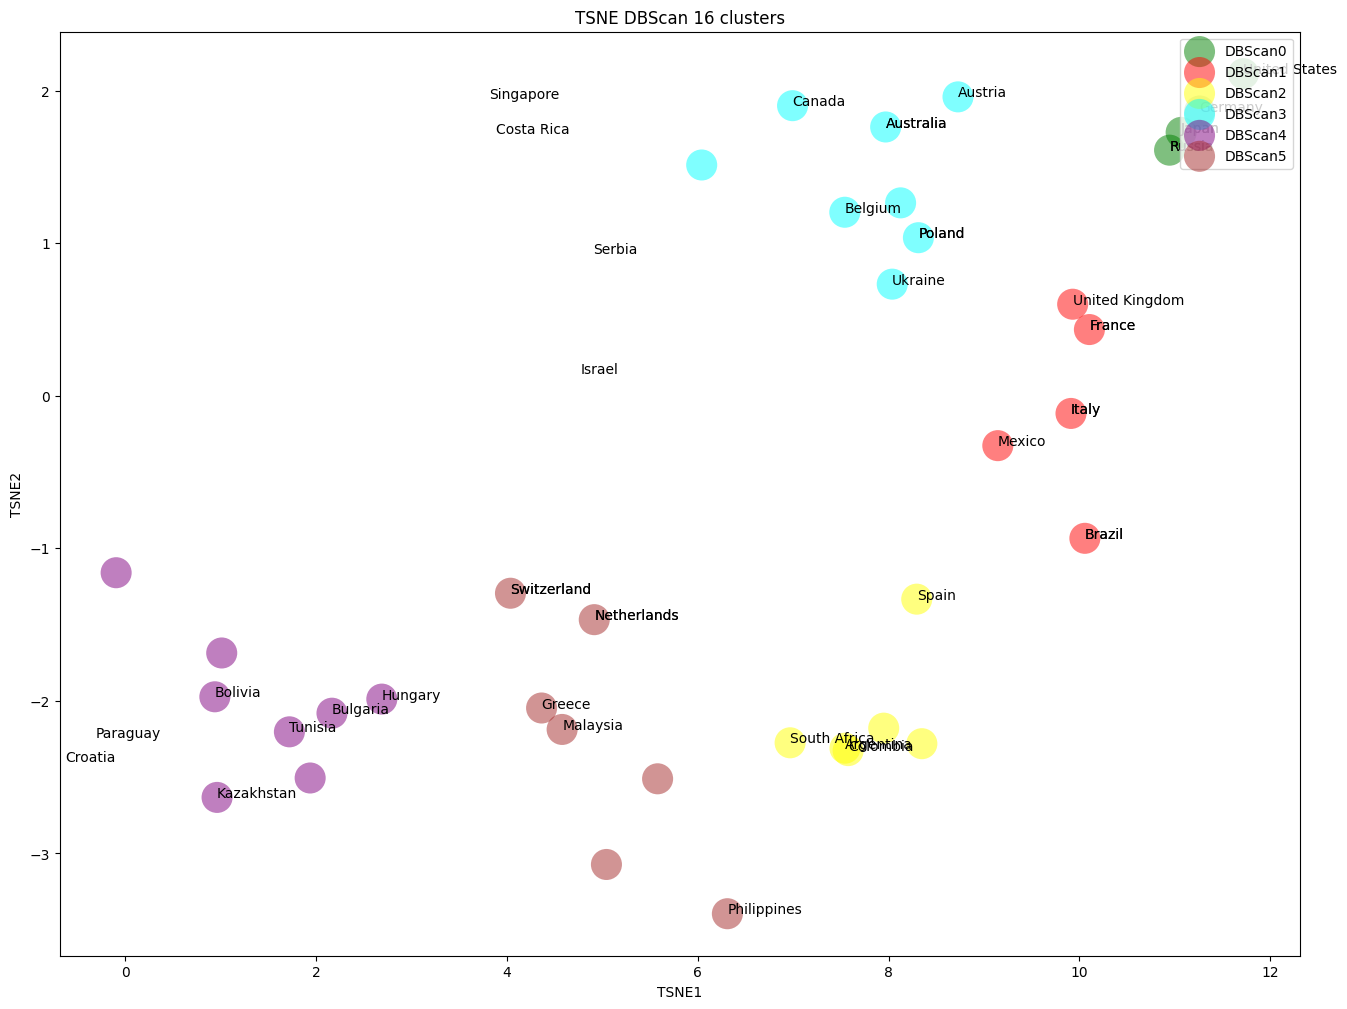

In [23]:
TSNE_df = TSNE_components.copy()
clustering = DBSCAN(eps=1.25, min_samples=4).fit(TSNE_df)
plot_big('DBScan','TSNE',clustering, TSNE_df, countries=100)

In [24]:
df_gmerged3.head()

,Country/Region,Deaths,Cases,Country Code,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
0,United States,1123836,103802702,USA,2016,323071755,49054.333333,30420.714286,31227.928571,551.666667,311.142857,308.214286
1,Brazil,699276,37076053,BRA,2016,206859578,0.000000,1798.428571,4793.500000,0.000000,11.285714,31.571429
2,India,530779,44690738,IND,2016,1338636340,381.666667,335.714286,278.285714,1.333333,1.000000,1.071429
3,Russia,388478,22075858,RUS,2016,144342397,11661.000000,12535.428571,12031.571429,41.000000,39.571429,36.357143
4,Mexico,333188,7483444,MEX,2016,121519221,4263.666667,3369.142857,2878.071429,29.333333,21.428571,17.857143


In [25]:
dfc_g['Russia']
df_gmerged3[df_gmerged3['Country/Region'] == 'Russia']

,Country/Region,Deaths,Cases,Country Code,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
3,Russia,388478,22075858,RUS,2016,144342397,11661.0,12535.428571,12031.571429,41.0,39.571429,36.357143


In [26]:
import plotly.graph_objects as go
import pandas as pd

df = df_gmerged3.copy()

fig = go.Figure(data=go.Choropleth(
    locations = df['Country Code'],
    z = df['Cases'].apply(np.log),
    text = df['Country/Region'],
    colorscale = 'Reds',
#    colorscale = ['rgb(245,245,245)', 'rgb(254,224,210)', 'rgb(252,187,161)', 'rgb(252,146,114)', 'rgb(251,106,74)', 'rgb(239,59,44)', 'rgb(203,24,29)', 'rgb(165,15,21)', 'rgb(103,0,13)'],
    autocolorscale=False,
    colorbar=dict(
            title="Cases",
            titleside="top",
            tickmode="array",
            tickvals=[2, 4 ,7, 9, 11, 13],
            ticktext=["10", "100", "500", "1k",  "50k", "300k+"],
            ticks="outside"
        )))

fig.update_layout(
    title_text='Global COVID Cases',
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular' ),
    annotations = [dict(
        x=0.55, y=0.1,
        xref='paper', yref='paper',
        text='Source: <a href="https://github.com/dougfoo/machineLearning/covid"> John Hopkins + WorldBank</a>',
        showarrow = False
    )]
)

fig.show()
